# Librerias

In [1]:
random_state = 43992294
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
import seaborn as sns
from scipy.stats import chi2_contingency
import scipy.stats as ss
import os
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MultiLabelBinarizer

from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer

import ast

import warnings

from tqdm.auto import tqdm

from sklearn.feature_selection import RFECV

from sklearn.model_selection import StratifiedKFold, cross_val_score

from itertools import chain

import dask.dataframe as dd

from sklearn.utils import resample

from sklearn.neighbors import NearestNeighbors

# Cython imports
from tools import agrupar_categorias_cython, custom_one_hot_encoder_cython, boolean_features_ohe_cython, agrupar_edades_cython, expand_action_list_0_cython

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Funciones

In [2]:
warnings.filterwarnings('ignore')
tqdm.pandas()

# Agrega filas que contienen categorías desconocidas o raras (poca frecuencia) al conjunto de entrenamiento
def augment_train_data(main_train_df, supplementary_df, umbral_raras=100):
    """
    Agrega filas del dataset suplementario al conjunto de entrenamiento principal
    basándose en categorías desconocidas y raras, evitando la duplicación de filas.

    Parámetros:
    - main_train_df (pd.DataFrame): DataFrame principal de entrenamiento.
    - supplementary_df (pd.DataFrame): DataFrame suplementario del cual se extraerán las filas.
    - umbral_raras (int): Umbral de frecuencia para considerar una categoría como rara.

    Retorna:
    - main_train_df (pd.DataFrame): DataFrame de entrenamiento actualizado.
    - categorias_desconocidas (dict): Diccionario actualizado de categorías desconocidas.
    - categorias_raras (dict): Diccionario actualizado de categorías raras.
    """
    # Definir columnas que no deseas tratar como categóricas
    columns_to_exclude = ['auction_list_0', 'action_list_1', 'action_list_2', 'auction_time']

    # Identificar columnas categóricas excluyendo las especificadas
    categorical_features = main_train_df.select_dtypes(include=['object']).columns.tolist()
    categorical_features = [col for col in categorical_features if col not in columns_to_exclude]
    
    # Crear un diccionario para almacenar las categorías desconocidas por columna
    categorias_desconocidas = {}
    
    # Iterar a través de cada columna categórica para identificar categorías desconocidas
    for columna in categorical_features:
        # Obtener las categorías únicas en el conjunto de entrenamiento
        categorias_train = set(main_train_df[columna].dropna().unique())
        
        # Obtener las categorías únicas en el dataset suplementario
        categorias_suplementario = set(supplementary_df[columna].dropna().unique())
        
        # Identificar las categorías en el dataset suplementario que no están en el entrenamiento
        desconocidas = categorias_suplementario - categorias_train
        
        # Almacenar las categorías desconocidas en el diccionario como una lista
        categorias_desconocidas[columna] = list(desconocidas)
    
    # Inicializar el diccionario para almacenar las categorías raras por columna
    categorias_raras = {}
    
    # Identificar categorías raras en el conjunto de entrenamiento
    for columna in categorical_features:
        # Contar la frecuencia de cada categoría
        frecuencia = main_train_df[columna].value_counts()
        
        # Identificar categorías que aparecen menos de umbral_raras veces
        raras = frecuencia[frecuencia < umbral_raras].index.tolist()
        
        # Almacenar en el diccionario
        categorias_raras[columna] = raras
    
    # Crear una máscara booleana para filas con categorías desconocidas o raras
    mask_desconocidas = pd.Series([False] * len(supplementary_df))
    mask_raras = pd.Series([False] * len(supplementary_df))
    
    for columna in categorical_features:
        # Actualizar la máscara para categorías desconocidas
        if categorias_desconocidas[columna]:
            mask_desconocidas = mask_desconocidas | supplementary_df[columna].isin(categorias_desconocidas[columna])
        
        # Actualizar la máscara para categorías raras
        if categorias_raras[columna]:
            mask_raras = mask_raras | supplementary_df[columna].isin(categorias_raras[columna])
    
    # Combinar ambas máscaras
    mask_total = mask_desconocidas | mask_raras
    
    # Filtrar filas únicas a agregar
    filas_a_agregar = supplementary_df[mask_total].drop_duplicates()
    
    # Mostrar información de agregación
    total_agregadas = len(filas_a_agregar)
    print(f"\nAgregando {total_agregadas} filas del dataset suplementario basadas en categorías desconocidas o raras.")
    
    # Agregar las filas al conjunto de entrenamiento
    main_train_df = pd.concat([main_train_df, filas_a_agregar], ignore_index=True)
    
    # Actualizar los diccionarios eliminando las categorías que ya han sido agregadas
    for columna in categorical_features:
        # Actualizar categorías desconocidas
        if categorias_desconocidas[columna]:
            categorias_agregadas = filas_a_agregar[columna].unique().tolist()
            categorias_desconocidas[columna] = [cat for cat in categorias_desconocidas[columna] if cat not in categorias_agregadas]
        
        # Actualizar categorías raras
        if categorias_raras[columna]:
            # Recontar la frecuencia después de agregar
            frecuencia = main_train_df[columna].value_counts()
            nuevas_raras = frecuencia[frecuencia < umbral_raras].index.tolist()
            categorias_raras[columna] = nuevas_raras
    
    return main_train_df, categorias_desconocidas, categorias_raras

# Agrega como columnas binarias las listas de la columna 'auction_list_0', 'action_list_1' y 'action_list_2'
def expand_list_dummies_cython(df, column, delimiter='|', prefix=None, suffix=None):
    """
    Expande una columna que contiene listas en múltiples columnas binarias usando un one-hot encoder optimizado con Cython.
    
    Parameters:
    - df (pd.DataFrame): DataFrame de pandas.
    - column (str): Nombre de la columna a expandir.
    - delimiter (str): Delimitador a usar en get_dummies (por defecto '|').
    - prefix (str, optional): Prefijo para las nuevas columnas binarias.
    - suffix (str, optional): Sufijo para las nuevas columnas binarias.
    
    Returns:
    - df_expanded (pd.DataFrame): DataFrame con las nuevas columnas binarias añadidas y la columna original eliminada.
    """
    print(f"Comenzando la expansión de la columna: '{column}'")
    
    # Copiar el DataFrame para evitar modificar el original
    df = df.copy()
    
    # Reemplazar NaN por listas vacías
    print(f"Reemplazando NaN en la columna '{column}' por listas vacías.")
    df[column] = df[column].fillna('[]')
    
    # Definir la función de parsing con impresión de errores
    def parse_list(x):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                # Convertir todos los elementos a strings
                return [str(item) for item in parsed]
            else:
                # Si no es una lista, tratar como un solo elemento
                return [str(x)]
        except (ValueError, SyntaxError):
            # En caso de error al parsear, retornar una lista vacía
            return []
    
    # Aplicar la función de parsing con una barra de progreso
    df[column] = df[column].progress_apply(parse_list)
    
    # Convertir la columna en una lista de listas para pasarla a la función Cythonizada
    data_list = df[column].tolist()
    
    # Llamar a la función optimizada en Cython
    unique_categories, binary_matrix = custom_one_hot_encoder_cython(data_list)
    print(f"Codificación completada. {len(unique_categories)} categorías únicas encontradas.")
    
    # Crear un DataFrame binario usando la matriz devuelta por Cython
    binary_df = pd.DataFrame(binary_matrix, index=df.index, columns=unique_categories)

    if prefix:
        binary_df = binary_df.add_prefix(f"{prefix}_")
    if suffix:
        binary_df = binary_df.add_suffix(f"_{suffix}")
    
    # Concatenar las columnas binarias al DataFrame original con una barra de progreso
    print("Concatenando las columnas binarias al DataFrame original.")
    for col in tqdm(binary_df.columns, desc="Concatenando columnas binarias"):
        if col in df.columns:
            df[col] = np.where((df[col] == 1) | (binary_df[col] == 1), 1, 0)
        else:
            df[col] = binary_df[col]
    
    # Eliminar la columna original ya que ha sido expandida
    print(f"Eliminando la columna original '{column}' del DataFrame.")
    df = df.drop(columns=[column])
    
    print(f"Expansión de la columna '{column}' completada exitosamente.\n")
    
    return df

# One-hot encode de columnas booleanas utilizando Cython
def boolean_features_ohe(df, columns_to_encode=['auction_boolean_0', 'auction_boolean_1', 'auction_boolean_2']):
    """
    Realiza one-hot encoding en columnas booleanas especificadas utilizando una función optimizada con Cython.
    Además, muestra el progreso del procesamiento utilizando tqdm y añade comentarios explicativos.

    Parámetros:
    - df (pd.DataFrame): DataFrame original que contiene las columnas booleanas a codificar.
    - columns_to_encode (list): Lista de nombres de columnas booleanas a codificar.

    Retorna:
    - df_expanded (pd.DataFrame): DataFrame con las nuevas columnas codificadas añadidas y las columnas booleanas originales eliminadas.
    """
    # Copiar el DataFrame para evitar modificar el original
    df = df.copy()
    print("Inicio del proceso de one-hot encoding para las columnas booleanas especificadas.")

    # Paso 1: Encontrar todos los valores únicos en las columnas a codificar
    unique_values_set = set()
    print("Recopilando valores únicos de las columnas a codificar:")
    for col in tqdm(columns_to_encode, desc="Procesando columnas para valores únicos"):
        unique_vals_col = df[col].dropna().unique()
        unique_values_set.update(unique_vals_col)
    unique_values = sorted(unique_values_set)
    print(f"Valores únicos encontrados: {unique_values}")

    # Paso 2: Convertir las columnas a listas de listas para ser procesadas en Cython
    list_data = []
    print("Convirtiendo las columnas booleanas a listas de listas para Cython:")
    for col in tqdm(columns_to_encode, desc="Convertir columnas a listas"):
        column_list = df[col].astype(str).tolist()  # Mantener los valores como strings
        list_data.append(column_list)
    print("Conversión completada.")

    # Paso 3: Procesar los datos con la función optimizada en Cython
    print("Realizando one-hot encoding utilizando la función optimizada en Cython:")
    ohe_result = boolean_features_ohe_cython(list_data, unique_values)
    print("One-hot encoding completado.")

    # Paso 4: Convertir el resultado de Cython a un DataFrame, alineando el índice con df
    print("Creando el DataFrame de columnas codificadas:")
    ohe_df = pd.DataFrame(ohe_result, columns=unique_values, index=df.index)
    print(f"DataFrame de one-hot encoding creado con {len(ohe_df.columns)} columnas y {ohe_df.shape[0]} filas.")

    # Paso 5: Concatenar las nuevas columnas codificadas al DataFrame original
    print("Concatenando las columnas codificadas al DataFrame original:")
    df_expanded = pd.concat([df, ohe_df], axis=1)
    print(f"Concatenación completada. El DataFrame ahora tiene {df_expanded.shape[1]} columnas y {df_expanded.shape[0]} filas.")

    # Paso 6: Eliminar las columnas booleanas originales del DataFrame
    print("Eliminando las columnas booleanas originales del DataFrame:")
    df_expanded.drop(columns=columns_to_encode, inplace=True)
    print(f"Columnas eliminadas: {columns_to_encode}")

    print("Proceso de one-hot encoding finalizado exitosamente.\n")

    return df_expanded

# Extensión de características temporales (día de la semana, momento del día, etc.) y festividades
def time_features_extension(df):
    """
    Procesa las características temporales del DataFrame y agrega nuevas columnas derivadas relacionadas con el tiempo y festividades.
    """

    # Convertir 'auction_time' de timestamp a una fecha legible
    df['auction_time'] = pd.to_datetime(df['auction_time'], unit='s')

    # Reemplazar NaN en 'timezone_offset' por 0
    df['timezone_offset'] = df['timezone_offset'].fillna(0)

    # Ajustar la hora según el 'timezone_offset' para obtener la hora local
    df['auction_time_local'] = df.apply(
        lambda row: row['auction_time'] + pd.DateOffset(hours=row['timezone_offset']), axis=1
    )

    # Crear la columna 'week_day' (1 para lunes, 7 para domingo)
    df['week_day'] = df['auction_time_local'].dt.weekday + 1

    # Crear la columna 'moment_of_the_day' (1 para temprano, 2 para tarde, 3 para noche)
    df['moment_of_the_day'] = pd.cut(df['auction_time_local'].dt.hour, 
                                     bins=[0, 12, 18, 24], labels=[1, 2, 3], include_lowest=True, right=False)

    # Eliminar las columnas originales 'auction_time', 'timezone_offset' y 'auction_time_local'
    df.drop(columns=['auction_time', 'timezone_offset', 'auction_time_local'], inplace=True)

    return df

# Agrupación de edades en rangos numéricos
def age_group(df, columna_edad):
    """
    Agrupa las edades en rangos numéricos utilizando Cython para mejorar el rendimiento.

    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene la columna de edades.
    - columna_edad (str): Nombre de la columna que contiene las edades.

    Retorna:
    - df (pd.DataFrame): DataFrame con la nueva columna 'age_group' que representa el rango de edad.
    """
    # Convertir la columna de edad a una lista
    edades = df[columna_edad].tolist()

    # Usar la función Cythonizada para agrupar las edades
    df['age_group'] = agrupar_edades_cython(edades)

    # Eliminar la columna original de edades
    df.drop(columns=[columna_edad], inplace=True)

    return df

# Agrupo action_list_0 a auction_list_0
def expand_action_list_0(df):
    """
    Expande la columna 'action_list_0' en valores únicos y marca con 1 las columnas existentes o las crea si es necesario.

    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene la columna 'action_list_0' y otras columnas de listas ya expandidas.

    Retorna:
    - df (pd.DataFrame): DataFrame actualizado con las columnas de valores únicos de 'action_list_0'.
    """

    # Convertir la columna 'action_list_0' y las columnas existentes a listas
    action_list_0 = df['action_list_0'].tolist()
    existing_columns = df.columns.tolist()
    
    # Inicializar la matriz actual
    current_matrix = df.values.tolist()

    # Llamar a la función Cythonizada
    updated_matrix = expand_action_list_0_cython(action_list_0, existing_columns, current_matrix)

    # Convertir la matriz actualizada de vuelta a un DataFrame
    df_updated = pd.DataFrame(updated_matrix, columns=existing_columns)

    # Eliminar la columna 'action_list_0'
    df_updated.drop(columns=['action_list_0'], inplace=True)

    return df_updated

# Concateno las categorias de cada nivel
def create_level_combination(df):
    """
    Creates a new column 'level_combination' by concatenating the first three characters 
    of each 'action_categorical' level columns and removes the original level columns.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the columns:
      'action_categorical_0', 'action_categorical_1', 'action_categorical_2', 
      'action_categorical_3', 'action_categorical_4'.

    Returns:
    - pd.DataFrame: The DataFrame with the new 'level_combination' column and without the original level columns.
    """
    level_columns = [
        'action_categorical_0',
        'action_categorical_1',
        'action_categorical_2',
        'action_categorical_3',
        'action_categorical_4'
    ]
    df['level_combination'] = df[level_columns].astype(str).apply(
        lambda x: ''.join([s[:3] for s in x]), axis=1
    )
    df.drop(columns=level_columns, inplace=True)
    return df

# Heigh x Width a columna
def hxw_column(df):
    """
    Crea una nueva columna 'hxw' multiplicando 'creative_height' y 'creative_width'.
    Si alguno de los dos tiene un NaN, 'hxw' se establece en 0.
    Elimina las columnas originales 'creative_height' y 'creative_width'.
    
    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene las columnas 'creative_height' y 'creative_width'.
    
    Retorna:
    - pd.DataFrame: DataFrame con la nueva columna 'hxw' añadida y las columnas originales eliminadas.
    """
    df['hxw'] = df['creative_height'] * df['creative_width']
    df.loc[df['creative_height'].isna() | df['creative_width'].isna(), 'hxw'] = 0
    df.drop(columns=['creative_height', 'creative_width'], inplace=True)
    return df

# Gender to number
def encode_gender(df):
    """
    Reemplaza los valores de la columna 'gender' de la siguiente manera:
    'f' -> 1, 'm' -> 2, 'o' -> 0 y NaN -> -1.
    
    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene la columna 'gender'.
    
    Retorna:
    - pd.DataFrame: DataFrame con la columna 'gender' codificada.
    """
    df['gender'] = df['gender'].map({'f': 1, 'm': 2, 'o': 0}).fillna(-1).astype(int)
    return df

# creative_categorical_11, creative_categorical_9 y creative_categorical_10 a dos columnas
def creatives2unique(df):
    """
    Crea o actualiza dos columnas en el DataFrame, una para cada valor único en las columnas
    'creative_categorical_11', 'creative_categorical_10', y 'creative_categorical_9'.
    Si las columnas ya existen, actualiza los valores a 1 donde ese valor aparece en alguna
    de las tres columnas en esa fila.

    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene las columnas 'creative_categorical_11',
                         'creative_categorical_10', y 'creative_categorical_9'.

    Retorna:
    - pd.DataFrame: DataFrame con las nuevas columnas añadidas o actualizadas.
    """
    unique_values = {'65dcab89', '43c867fd'}
    columns_to_check = [
        'creative_categorical_11',
        'creative_categorical_10',
        'creative_categorical_9'
    ]

    for val in unique_values:
        if val in df.columns:
            # Si la columna ya existe, actualizamos los valores a 1 donde corresponde
            df[val] = df[val] | df[columns_to_check].eq(val).any(axis=1).astype(int)
        else:
            # Si no existe, creamos la columna con 1 donde corresponde
            df[val] = df[columns_to_check].eq(val).any(axis=1).astype(int)

    # Eliminar las columnas originales
    df.drop(columns=columns_to_check, inplace=True)
    
    return df

# Juntar todas las variables categoricas y hacer OHE
def process_combineta(df):
    """
    Procesa las columnas proporcionadas en combineta, creando un set con valores únicos,
    y generando columnas binarias para cada uno de esos valores. Si la columna ya existe,
    actualiza las filas con un 1 donde corresponda. Luego, elimina las columnas originales.

    Parámetros:
    - df (pd.DataFrame): DataFrame original.
    - combineta_columns (list): Lista de columnas a procesar.

    Retorna:
    - df (pd.DataFrame): DataFrame con las columnas binarias añadidas y las columnas originales eliminadas.
    """
    combineta_columns = ['creative_categorical_0', 'creative_categorical_5', 'auction_categorical_0', 'auction_categorical_1', 'auction_categorical_11', 'auction_categorical_7', 'auction_categorical_8', 'auction_categorical_9', 'action_categorical_6', 'action_categorical_7', 'auction_categorical_3', 'auction_categorical_4', 'auction_categorical_5', 'auction_categorical_6', 'auction_categorical_10', 'auction_categorical_12', 'creative_categorical_1', 'creative_categorical_12', 'creative_categorical_2', 'creative_categorical_3', 'creative_categorical_4', 'creative_categorical_6', 'creative_categorical_7', 'creative_categorical_8']

    # Unir todas las columnas de combineta en una sola columna de listas
    df['combined_combineta'] = df[combineta_columns].astype(str).agg(
        lambda x: '[' + ', '.join([f"'{str(item).strip()}'" for item in x if item != 'nan']) + ']', axis=1)

    # Usar la función expand_list_dummies_cython para descomponer la lista y crear las columnas binarias
    df = expand_list_dummies_cython(df, 'combined_combineta')
    
    df.drop(columns=combineta_columns, inplace=True, errors='raise')
    
    return df

# Procesamiento optimizado de un DataFrame
def process_optimized(df):
    """
    Aplica una serie de transformaciones al DataFrame utilizando una función Cython optimizada.
    
    Parámetros:
    - df (pd.DataFrame): DataFrame a procesar.
    
    Retorna:
    - df (pd.DataFrame): DataFrame procesado.
    """
    # Definir el número total de pasos para la barra de progreso
    total_steps = 14
    
    # Inicializar la barra de progreso
    with tqdm(total=total_steps, desc="Procesando DataFrame", unit="paso") as pbar:
        
        print("Comenzando el procesamiento optimizado del DataFrame.")
        print("Eliminando columnas innecesarias.")
        df = df.drop('action_categorical_5', axis=1)
        df = df.drop('auction_categorical_2', axis=1)
        pbar.update(1)

        print("Expansión de columnas temporales")
        df = time_features_extension(df)
        pbar.update(1)

        df = age_group(df, 'auction_age')
        pbar.update(1)

        print("Agrupando columnas de nivel")
        df = create_level_combination(df)
        pbar.update(1)

        print("Modificando columnas de genero")
        df = encode_gender(df)
        pbar.update(1)
        
        print("Modificando columna de video")
        df['has_video'] = df['has_video'].apply(lambda x: 1 if x == True else 0)
        pbar.update(1)

        print("Juntando medidas")
        df = hxw_column(df)
        pbar.update(1)

        print("Expansión de columnas booleanas.")
        df = boolean_features_ohe(df)
        pbar.update(1)

        print("Creando columnas de creatividad")
        df = creatives2unique(df)
        pbar.update(1)
        
        columns_to_expand = ['auction_list_0', 'action_list_1']

        # Bucle para realizar las operaciones
        for col in columns_to_expand:
            print(f"Expansión de columnas de listas para {col}.")
            
            # Crear la variable 'idx_position' con la última columna antes de la expansión
            idx_position = df.columns.get_loc(df.columns[-1])
            
            # Expansión de la columna
            df = expand_list_dummies_cython(df, col)
            pbar.update(1)

            if col == 'action_list_1':
                df = expand_list_dummies_cython(df,'action_list_2')
                pbar.update(1)
            
            if col == 'auction_list_0':
                # Bucle para recorrer las columnas que empiezan con 'AND' o 'APL'
                if 'AND-APL' not in df.columns:
                    df['AND-APL'] = 0  # Inicializar la columna 'AND-APL'

                for column in df.columns:
                    if column.startswith('AND') or column.startswith('APL'):
                        # Poner un 1 en 'AND-APL' si la columna actual tiene un 1 en esa fila
                        df['AND-APL'] = df['AND-APL'] | df[column]

                # Eliminar todas las columnas que empiezan con 'AND' o 'APL' excepto la columna 'AND-APL'
                columns_to_drop = [column for column in df.columns if (column.startswith('AND') or column.startswith('APL')) and column != 'AND-APL']
                df.drop(columns=columns_to_drop, inplace=True)

                print("Complementamos con la columna 'action_list_0'")
                df = expand_action_list_0(df)
                pbar.update(1)

            # Crear la lista de columnas numéricas a partir de la siguiente columna después de 'idx'
            categorical_num = df.iloc[:, idx_position:].select_dtypes(include=['number']).columns

            # Eliminar columnas numéricas con menos de 1000 valores iguales a 1
            for column in categorical_num:
                if (df[column] == 1).sum() < 1000 and column != 'AND-APL':
                    df.drop(column, axis=1, inplace=True)
    
        
        print("Agrupando categorias poco frecuentes")

        categorical_str = df.select_dtypes(include=['object']).columns
        categorical_str = categorical_str[categorical_str != 'device_id']
        
        categorical_num = df.select_dtypes(include=['number']).columns
        
        # Convertir a matriz bidimensional
        data_matrix = df[categorical_str].values.tolist()
        data_matrix_cython = [list(row) for row in data_matrix]
        
        # Llamar a la función Cythonizada
        df_cython_data = agrupar_categorias_cython(
            categorical_features=categorical_str.tolist(),
            data=data_matrix_cython,
            umbral=1000  # Umbral de frecuencia para considerar una categoría como rara
        )

        # Reasignar los datos al DataFrame
        for i, col in enumerate(categorical_str):
            df[col] = [row[i] for row in df_cython_data]

        idx_position = df.columns.get_loc(df.columns[-1])
        
        df = process_combineta(df)

        # Crear la lista de columnas numéricas a partir de la siguiente columna después de 'idx'
        categorical_num = df.iloc[:, idx_position:].select_dtypes(include=['number']).columns

        # Eliminar columnas numéricas con menos de 1000 valores iguales a 1
        for column in categorical_num:
            if (df[column] == 1).sum() < 1000:
                df.drop(column, axis=1, inplace=True)

        pbar.update(1)

        
    return df

# Función para ajustar el tipo de datos de una columna para que Dask tome Nan como valor válido
def adjust_dtype(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'Int64'
    elif pd.api.types.is_float_dtype(dtype):
        return 'float64'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'boolean'
    else:
        return 'object'
    
# Procesamiento de datos con Dask
def process_data_with_dask(df, npartitions=10, meta_df=None):
    """
    Procesa un DataFrame utilizando Dask para distribuir el trabajo en varias particiones.
    Aplica la función process_optimized a cada partición del DataFrame.

    Parámetros:
    - df (pd.DataFrame): El DataFrame de pandas a procesar.
    - npartitions (int): Número de particiones en las que se dividirá el DataFrame para su procesamiento.

    Retorna:
    - final_df (pd.DataFrame): El DataFrame procesado y concatenado.
    """
    # Convertir el DataFrame de pandas a Dask con el número de particiones especificado
    dask_df = dd.from_pandas(df, npartitions=npartitions)
    
    # Crear el meta DataFrame con tipos ajustados
    meta = df.head(0).copy()
    for col in meta.columns:
        meta[col] = meta[col].astype(adjust_dtype(df[col].dtype))
        
    # Aplicar la función con map_partitions y especificar el meta
    dask_df = dask_df.map_partitions(
        lambda df_partition: process_optimized(df_partition),
        meta=meta
    )

    # Ejecutar el cálculo distribuido y convertir el resultado a pandas
    final_df = dask_df.compute()

    return final_df

# Función para calcular la estadística de Cramér's V
def cramers_v(confusion_matrix):
    """
    Calcula la estadística de Cramér's V para medir la asociación entre dos variables categóricas.

    Parameters:
    - confusion_matrix: Matriz de confusión (tabla de contingencia) entre dos variables.

    Returns:
    - Cramér's V: Valor entre 0 y 1 que indica la fuerza de la asociación.
    """
    # Calcular el estadístico chi-cuadrado
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    # Número total de observaciones
    n = confusion_matrix.sum().sum()
    # Obtener el número de filas y columnas de la matriz de confusión
    r, k = confusion_matrix.shape
    if min(r, k) == 1:
        return np.nan  # Evitar dividir por cero
    # Calcular Cramér's V
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def handle_none(value):
    return 'None' if value is None else str(value)

# Lectura de datos

In [ ]:
train_data = pd.read_csv('train_data_combined.csv')

In [4]:
train_data.shape

(8456028, 52)

In [13]:
train_data_combined, _ = train_test_split(
    train_data, 
    train_size=1000000, 
    random_state=random_state, 
    stratify=train_data['Label']
)

In [ ]:
train_data = process_optimized(train_data_combined)

Procesando DataFrame:   0%|          | 0/14 [00:00<?, ?paso/s]

Comenzando el procesamiento optimizado del DataFrame.
Eliminando columnas innecesarias.
Expansión de columnas temporales


# Graficos

## Correlaciones


Porcentaje de Datos Faltantes por Característica:
creative_categorical_3: 94.24%
creative_categorical_7: 85.66%
creative_categorical_6: 85.59%
creative_categorical_12: 85.38%
creative_categorical_5: 84.56%
creative_categorical_2: 84.12%
auction_age: 80.58%
gender: 77.98%
auction_categorical_9: 29.74%
action_list_1: 24.28%
auction_categorical_12: 20.70%
action_list_2: 17.13%
creative_categorical_4: 15.45%
creative_width: 15.42%
creative_height: 15.42%
auction_categorical_6: 9.01%
auction_boolean_1: 3.20%
auction_boolean_2: 2.98%
auction_boolean_0: 1.83%
auction_list_0: 1.54%
creative_categorical_9: 1.21%
auction_categorical_2: 0.68%
auction_categorical_3: 0.43%
auction_categorical_0: 0.41%
auction_categorical_4: 0.35%
auction_categorical_11: 0.17%
timezone_offset: 0.10%
auction_categorical_7: 0.01%


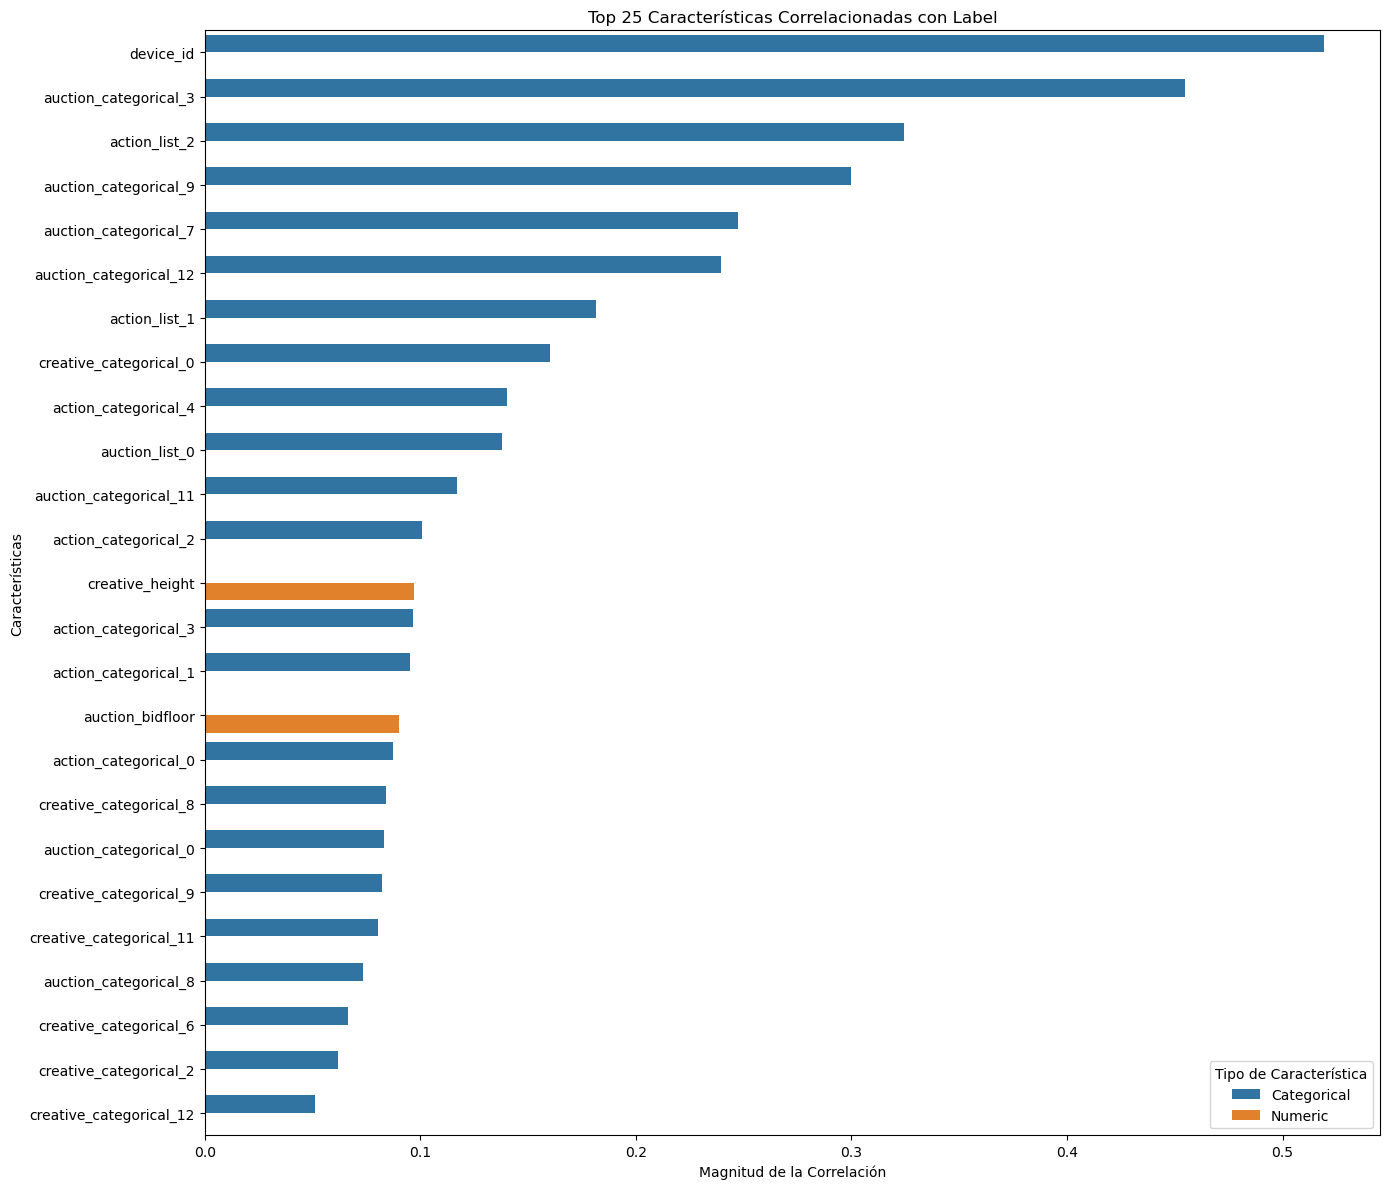

In [12]:
# Seleccionar las columnas numéricas
numeric_columns = train_data.select_dtypes(include=['number']).columns.tolist()

# Verificar que 'Label' esté en las columnas numéricas
if 'Label' not in numeric_columns:
    train_data['Label'] = train_data['Label'].astype(float)
    numeric_columns = train_data.select_dtypes(include=['number']).columns.tolist()

# Identificar las columnas categóricas
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()

# Remover 'Label' de las listas de características si está presente
if 'Label' in numeric_columns:
    numeric_columns.remove('Label')
if 'Label' in categorical_columns:
    categorical_columns.remove('Label')

# Análisis de correlación con 'Label' para características numéricas
correlation_with_label = train_data[numeric_columns + ['Label']].corr()['Label'].abs().sort_values(ascending=False)

# Eliminar 'Label' de la lista
correlation_with_label = correlation_with_label.drop('Label')

# Crear un DataFrame para las correlaciones numéricas
corr_num_df = pd.DataFrame({
    'Feature': correlation_with_label.index,
    'CorrelationValue': correlation_with_label.values,
    'Type': 'Numeric'
})

# Análisis de asociación con 'Label' para características categóricas usando Cramer's V
cramers_v_results = []

for col in categorical_columns:
    confusion_matrix = pd.crosstab(train_data[col], train_data['Label'])
    if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        # Evitar cálculos de Cramer's V cuando no hay suficientes categorías
        cramers_v_val = np.nan
    else:
        cramers_v_val = cramers_v(confusion_matrix)
    cramers_v_results.append({'Feature': col, 'CorrelationValue': cramers_v_val, 'Type': 'Categorical'})

# Crear un DataFrame para las correlaciones categóricas
corr_cat_df = pd.DataFrame(cramers_v_results).dropna().sort_values(by='CorrelationValue', ascending=False)

# Combinar ambos DataFrames
combined_corr_df = pd.concat([corr_num_df, corr_cat_df], ignore_index=True)

# Ordenar por la magnitud de la correlación
combined_corr_df = combined_corr_df.sort_values(by='CorrelationValue', ascending=False).reset_index(drop=True)

# Análisis de datos faltantes
missing_data = train_data.isnull().sum() / len(train_data) * 100
missing_data = missing_data.sort_values(ascending=False)

print("\nPorcentaje de Datos Faltantes por Característica:")
for feature, percentage in missing_data.items():
    if percentage > 0:  # Solo imprimir características con datos faltantes
        print(f"{feature}: {percentage:.2f}%")

# Visualizar las mayores correlaciones con 'Label'
plt.figure(figsize=(14, 12))
top_correlations = combined_corr_df.head(25)
sns.barplot(x=top_correlations['CorrelationValue'], y=top_correlations['Feature'], hue=top_correlations['Type'])
plt.title('Top 25 Características Correlacionadas con Label')
plt.xlabel('Magnitud de la Correlación')
plt.ylabel('Características')
plt.legend(title='Tipo de Característica')
plt.tight_layout()
plt.savefig('correlations.png')
plt.show()

## Missing values

In [ ]:
# Calcular el número de valores faltantes por columna
missing_values = train_data_combined.isnull().sum()

# Calcular el porcentaje de valores faltantes
missing_percent = (missing_values / len(train_data_combined)) * 100

# Crear un DataFrame con los resultados
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})

# Ordenar el DataFrame por el número de valores faltantes en orden descendente
missing_df = missing_df.sort_values(by='Missing Values', ascending=False)

# Seleccionar las top 15 columnas con más valores faltantes
top15_missing = missing_df.head(15)

# Seleccionar las 15 columnas con más valores faltantes
top15_cols = top15_missing.index.tolist()

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=top15_missing['Percentage'], y=top15_missing.index, palette='viridis')

# Añadir títulos y etiquetas
plt.title('Porcentaje de Valores Faltantes en las Top 15 Columnas', fontsize=16)
plt.xlabel('Porcentaje de Valores Faltantes (%)', fontsize=14)
plt.ylabel('Características', fontsize=14)

# Añadir etiquetas de porcentaje en las barras
for index, value in enumerate(top15_missing['Percentage']):
    plt.text(value + 0.5, index, f"{value:.2f}%", va='center')

plt.tight_layout()
plt.savefig('missing_values.png')
plt.show()


## ROC-AUCs

In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns='Label'),  # Características
    train_data['Label'],               # Variable objetivo
    test_size=0.2,                     # 20% para validación
    stratify=train_data['Label'],      # Estratificación basada en la variable objetivo
    random_state=random_state          # Semilla para reproducibilidad
)

In [35]:
# Identificar columnas categóricas y numéricas en train_data
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()

In [36]:
# Preprocesador común para imputación y codificación
preprocessor_ohe = ColumnTransformer(
    transformers=[
        # Imputar valores numéricos con la media
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        
        # Imputar valores categóricos con 'Desconocido' y aplicar One-Hot Encoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Desconocido')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'))
        ]), categorical_features)
    ],
    remainder='drop'
)

# Ajustar el preprocesador en el conjunto de entrenamiento y transformar ambos conjuntos
X_train_ohe = preprocessor_ohe.fit_transform(X_train)
X_val_ohe = preprocessor_ohe.transform(X_val)

# Obtener los nombres de las columnas después de la transformación
ohe_columns = preprocessor_ohe.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
processed_columns_ohe = numeric_features + list(ohe_columns)

In [ ]:
# Definir el preprocesador con Target Encoding e imputación
encoder_te = ce.TargetEncoder(cols=categorical_features)

# Ajustar y transformar el conjunto de entrenamiento y prueba
X_train_te = encoder_te.fit_transform(X_train, y_train)
X_val_te = encoder_te.transform(X_val)

# Escalar las características numéricas
scaler_te = StandardScaler()
X_train_te[numeric_features] = scaler_te.fit_transform(X_train_te[numeric_features])
X_val_te[numeric_features] = scaler_te.transform(X_val_te[numeric_features])

del X_train, X_val
gc.collect()

In [39]:
# Definir el espacio de búsqueda para XGBoost con OHE
space_xgb_ohe = {
    'max_depth': hp.choice('max_depth', range(3, 10)), 
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]), 
    'gamma': hp.uniform('gamma', 0, 0.5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.5, 2),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),  # L1 regularización
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),  # L2 regularización
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),  # Muestreo a nivel de split
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1),  # Muestreo por nodo
    'grow_policy': hp.choice('grow_policy', ['depthwise', 'lossguide']),  # Estrategia de crecimiento
    'tree_method': hp.choice('tree_method', ['auto', 'approx', 'hist'])  # Métodos de construcción del árbol
}

# Definir el espacio de búsqueda para XGBoost con TE
space_xgb_te = {
    'max_depth': hp.choice('max_depth', range(3, 10)), 
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]), 
    'gamma': hp.uniform('gamma', 0, 0.5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.5, 2),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),  # L1 regularización
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),  # L2 regularización
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),  # Muestreo a nivel de split
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1),  # Muestreo por nodo
    'grow_policy': hp.choice('grow_policy', ['depthwise', 'lossguide']),  # Estrategia de crecimiento
    'tree_method': hp.choice('tree_method', ['auto', 'approx', 'hist'])  # Métodos de construcción del árbol
}

# Definir el espacio de búsqueda para Random Forest con TE
space_rf_te = {
    'n_estimators': hp.choice('n_estimators_rf_te', range(100, 1000)),
    'max_depth': hp.choice('max_depth_rf_te', range(3, 20)),
    'min_samples_split': hp.uniform('min_samples_split_rf_te', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf_rf_te', 0.1, 0.5),
    'bootstrap': hp.choice('bootstrap_rf_te', [True, False]),
    'max_features': hp.choice('max_features_rf_te', ['sqrt', 'log2'])
}


In [42]:
# Definir la función objetivo para XGBoost con OHE
def objective_xgb_ohe(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    
    model = XGBClassifier(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        scale_pos_weight=params['scale_pos_weight'],
        reg_alpha=params['reg_alpha'],  # L1 regularización
        reg_lambda=params['reg_lambda'],  # L2 regularización
        colsample_bylevel=params['colsample_bylevel'],  # Muestreo a nivel de split
        colsample_bynode=params['colsample_bynode'],  # Muestreo por nodo
        grow_policy=params['grow_policy'],  # Estrategia de crecimiento
        tree_method=params['tree_method'],  # Método de construcción del árbolobjective='binary:logistic',
        random_state=random_state,
        use_label_encoder=False,
        eval_metric='auc',
    )
    model.fit(
        X_train_ohe, 
        y_train, 
        eval_set=[(X_val_ohe, y_val)],
        early_stopping_rounds=10,
        verbose=False
    )
    preds = model.predict_proba(X_val_ohe)[:,1]
    auc = roc_auc_score(y_val, preds)
    return {'loss': -auc, 'status': STATUS_OK}

# Definir la función objetivo para XGBoost con TE
def objective_xgb_te(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])

    model = XGBClassifier(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        scale_pos_weight=params['scale_pos_weight'],
        reg_alpha=params['reg_alpha'],  # L1 regularización
        reg_lambda=params['reg_lambda'],  # L2 regularización
        colsample_bylevel=params['colsample_bylevel'],  # Muestreo a nivel de split
        colsample_bynode=params['colsample_bynode'],  # Muestreo por nodo
        grow_policy=params['grow_policy'],  # Estrategia de crecimiento
        tree_method=params['tree_method'],  # Método de construcción del árbolobjective='binary:logistic',
        random_state=random_state,
        use_label_encoder=False,
        eval_metric='auc',
    )
    model.fit(
        X_train_te, 
        y_train, 
        eval_set=[(X_val_te, y_val)],
        early_stopping_rounds=10,
        verbose=False
    )
    preds = model.predict_proba(X_val_te)[:,1]
    auc = roc_auc_score(y_val, preds)
    return {'loss': -auc, 'status': STATUS_OK}

# Definir la función objetivo para Random Forest con TE
def objective_rf_te(params):
    model = RandomForestClassifier(
        random_state=random_state,
        **params
    )
    model.fit(
        X_train_te, 
        y_train
    )
    preds = model.predict_proba(X_val_te)[:,1]
    auc = roc_auc_score(y_val, preds)
    return {'loss': -auc, 'status': STATUS_OK}


In [ ]:
# Inicializar Trials para cada modelo y encoding
trials_xgb_ohe = Trials()
trials_rf_ohe = Trials()
trials_xgb_te = Trials()
trials_rf_te = Trials()

# Optimización Hyperopt para XGBoost con OHE
best_xgb_ohe = fmin(
    fn=objective_xgb_ohe,
    space=space_xgb_ohe,
    algo=tpe.suggest,
    max_evals=5,
    trials=trials_xgb_ohe,
    rstate=np.random.default_rng(random_state)
)

# Optimización Hyperopt para XGBoost con TE
best_xgb_te = fmin(
    fn=objective_xgb_te,
    space=space_xgb_te,
    algo=tpe.suggest,
    max_evals=5,
    trials=trials_xgb_te,
    rstate=np.random.default_rng(random_state)
)

# Optimización Hyperopt para Random Forest con TE
best_rf_te = fmin(
    fn=objective_rf_te,
    space=space_rf_te,
    algo=tpe.suggest,
    max_evals=5,
    trials=trials_rf_te,
    rstate=np.random.default_rng(random_state)
)

print("Mejores hiperparámetros XGBoost OHE:", best_xgb_ohe)
print("Mejores hiperparámetros XGBoost TE:", best_xgb_te)
print("Mejores hiperparámetros Random Forest TE:", best_rf_te)


In [ ]:
# Ajustar los hiperparámetros obtenidos para XGBoost con OHE
tree_method_options = ['auto', 'exact', 'approx', 'hist']
grow_policy_options = ['depthwise', 'lossguide']
n_estimators_options = [100, 200, 300, 400, 500]

# Entrenar el modelo final XGBoost con OHE
final_model_xgb_ohe = XGBClassifier(
    objective='binary:logistic',
    random_state=random_state,
    use_label_encoder=False,
    eval_metric='auc',
    n_estimators=n_estimators_options[best_xgb_ohe['n_estimators']],
    max_depth=best_xgb_ohe['max_depth'],
    learning_rate=best_xgb_ohe['learning_rate'],
    subsample=best_xgb_ohe['subsample'],
    colsample_bytree=best_xgb_ohe['colsample_bytree'],
    min_child_weight=best_xgb_ohe['min_child_weight'],
    gamma=best_xgb_ohe['gamma'],
    scale_pos_weight=best_xgb_ohe['scale_pos_weight'],
    reg_alpha=best_xgb_ohe['reg_alpha'],  # L1 regularización
    reg_lambda=best_xgb_ohe['reg_lambda'],  # L2 regularización
    colsample_bylevel=best_xgb_ohe['colsample_bylevel'],  # Muestreo a nivel de split
    colsample_bynode=best_xgb_ohe['colsample_bynode'],  # Muestreo por nodo
    grow_policy=grow_policy_options[best_xgb_ohe['grow_policy']],  # Estrategia de crecimiento
    tree_method=tree_method_options[best_xgb_ohe['tree_method']],  # Método de construcción del árbol
)

final_model_xgb_ohe.fit(
    X_train_ohe, 
    y_train, 
    eval_set=[(X_val_ohe, y_val)],
    early_stopping_rounds=10,
    verbose=False
)


In [ ]:
# Ajustar los hiperparámetros obtenidos para XGBoost con TE
tree_method_options = ['auto', 'exact', 'approx', 'hist']
grow_policy_options = ['depthwise', 'lossguide']
n_estimators_options = [100, 200, 300, 400, 500]

# Entrenar el modelo final XGBoost con TE
final_model_xgb_te = XGBClassifier(
    objective='binary:logistic',
    random_state=random_state,
    use_label_encoder=False,
    eval_metric='auc',
    n_estimators=n_estimators_options[best_xgb_ohe['n_estimators']],
    max_depth=best_xgb_ohe['max_depth'],
    learning_rate=best_xgb_ohe['learning_rate'],
    subsample=best_xgb_ohe['subsample'],
    colsample_bytree=best_xgb_ohe['colsample_bytree'],
    min_child_weight=best_xgb_ohe['min_child_weight'],
    gamma=best_xgb_ohe['gamma'],
    scale_pos_weight=best_xgb_ohe['scale_pos_weight'],
    reg_alpha=best_xgb_ohe['reg_alpha'],  # L1 regularización
    reg_lambda=best_xgb_ohe['reg_lambda'],  # L2 regularización
    colsample_bylevel=best_xgb_ohe['colsample_bylevel'],  # Muestreo a nivel de split
    colsample_bynode=best_xgb_ohe['colsample_bynode'],  # Muestreo por nodo
    grow_policy=grow_policy_options[best_xgb_ohe['grow_policy']],  # Estrategia de crecimiento
    tree_method=tree_method_options[best_xgb_ohe['tree_method']],  # Método de construcción del árbol
)

final_model_xgb_te.fit(
    X_train_te, 
    y_train, 
    eval_set=[(X_val_te, y_val)],
    early_stopping_rounds=10,
    verbose=False
)


In [ ]:
# Ajustar los hiperparámetros obtenidos para Random Forest con TE
best_params_rf_te = {
    'n_estimators': best_rf_te['n_estimators_rf_te'] + 100,
    'max_depth': best_rf_te['max_depth_rf_te'] + 3,
    'min_samples_split': best_rf_te['min_samples_split_rf_te'],
    'min_samples_leaf': best_rf_te['min_samples_leaf_rf_te'],
    'bootstrap': [True, False][best_rf_te['bootstrap_rf_te']],
    'max_features': ['sqrt', 'log2'][best_rf_te['max_features_rf_te']]
}

# Entrenar el modelo final Random Forest con TE
final_model_rf_te = RandomForestClassifier(
    random_state=random_state,
    **best_params_rf_te
)

final_model_rf_te.fit(
    X_train_te, 
    y_train
)

In [49]:
# Calcular las predicciones y ROC AUC para XGBoost con OHE
preds_xgb_ohe = final_model_xgb_ohe.predict_proba(X_val_ohe)[:,1]
fpr_xgb_ohe, tpr_xgb_ohe, _ = roc_curve(y_val, preds_xgb_ohe)
auc_xgb_ohe = roc_auc_score(y_val, preds_xgb_ohe)

# Calcular las predicciones y ROC AUC para XGBoost con TE
preds_xgb_te = final_model_xgb_te.predict_proba(X_val_te)[:,1]
fpr_xgb_te, tpr_xgb_te, _ = roc_curve(y_val, preds_xgb_te)
auc_xgb_te = roc_auc_score(y_val, preds_xgb_te)

# Calcular las predicciones y ROC AUC para Random Forest con TE
preds_rf_te = final_model_rf_te.predict_proba(X_val_te)[:,1]
fpr_rf_te, tpr_rf_te, _ = roc_curve(y_val, preds_rf_te)
auc_rf_te = roc_auc_score(y_val, preds_rf_te)


In [ ]:
# Opcional: Guardar el gráfico
plt.figure(figsize=(10, 8))

# XGBoost con One-Hot Encoding
plt.plot(fpr_xgb_ohe, tpr_xgb_ohe, label=f'XGBoost OHE (AUC = {auc_xgb_ohe:.2f})')

# XGBoost con Target Encoding
plt.plot(fpr_xgb_te, tpr_xgb_te, label=f'XGBoost TE (AUC = {auc_xgb_te:.2f})')

# Random Forest con Target Encoding
plt.plot(fpr_rf_te, tpr_rf_te, label=f'Random Forest TE (AUC = {auc_rf_te:.2f})')

# Línea diagonal
plt.plot([0, 1], [0, 1], 'k--')

# Configuración del gráfico
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC AUC de Modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_auc_curves.png')
plt.show()


# Comparación de modelos

## Recursive Feature Elimination

In [ ]:
# Separar las características (X) y el label (y)
X = train_data.drop('Label', axis=1)
y = train_data['Label']

In [ ]:
# Definir las columnas categóricas y numéricas
categorical_features_to_encode = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['number']).columns.tolist()

# Preprocesador común para imputación y codificación
common_preprocessor = ColumnTransformer(
    transformers=[
        # Imputar valores numéricos con la mediana
        ('num', SimpleImputer(strategy='median'), numeric_features),
        
        # Imputar valores categóricos con 'Desconocido' y aplicar One-Hot Encoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Desconocido')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'))
        ]), categorical_features_to_encode)
    ],
    remainder='drop'  # Excluir columnas no especificadas
)

# Definir el modelo XGBoost
model_xgb = XGBClassifier(
    random_state=random_state, 
    use_label_encoder=False, 
    eval_metric='auc'
)

# Crear el pipeline con RFECV y XGBoost
# Utilizamos StratifiedKFold para asegurar que se mantengan las proporciones de la clase
cv = StratifiedKFold(n_splits=5)

# Pipeline para XGBoost con RFECV
rfe_xgb = Pipeline([
    ('preprocessor', common_preprocessor),
    ('selector', RFECV(
        estimator=model_xgb,
        step=1,
        cv=cv,
        scoring='roc_auc',
        verbose=0,  # Desactiva la salida estándar de RFECV
        n_jobs=-1
    ))
])

# Ajustar el modelo con RFECV
print("Fitting XGBoost RFECV...")
rfe_xgb.named_steps['selector'].fit(X, y)

# Obtener el número óptimo de características
print('Optimal number of features (XGBoost model): {}'.format(rfe_xgb.named_steps['selector'].n_features_))

# Graficar la selección de características
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfe_xgb.named_steps['selector'].cv_results_['mean_test_score']) + 1),
         rfe_xgb.named_steps['selector'].cv_results_['mean_test_score'])
plt.title('Feature Number Selection (XGBoost)')
plt.xlabel("Number of Features Selected")
plt.ylabel("CV Score (ROC AUC)")
plt.show()

# Obtener los nombres de las características después del preprocesamiento
feature_names = (numeric_features +
                 rfe_xgb.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features_to_encode).tolist())

# Imprimir las características seleccionadas
print("\nFeatures selected by XGBoost:")
selected_features_xgb = [feature_names[i] for i, selected in enumerate(rfe_xgb.named_steps['selector'].support_) if selected]
print(selected_features_xgb)


## Backward Selection

In [6]:
# Dividir los datos en entrenamiento y validación con estratificación
X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns='Label'),  # Características
    train_data['Label'],               # Variable objetivo
    test_size=0.2,                     # 20% para validación
    stratify=train_data['Label'],      # Estratificación basada en la variable objetivo
    random_state=random_state          # Semilla para reproducibilidad
)

# Asegurarse de que X_train y X_val sean dataframes de pandas
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)

# Asegurarse de que y_train y y_val sean series de pandas
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)

In [7]:
# 1. Definir las opciones para 'tree_method' y 'grow_policy'
tree_method_options = ['auto', 'exact', 'approx', 'hist']
grow_policy_options = ['depthwise', 'lossguide']
n_estimators_options = [100, 200, 300, 400, 500]

# 2. Identificar las columnas categóricas y numéricas
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_columns = X_train.select_dtypes(include=['number']).columns.tolist()

# 3. Crear un preprocesador con imputación y One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        # Imputar valores numéricos faltantes con la media
        ('num', SimpleImputer(strategy='mean'), numeric_columns),
        
        # Imputar valores categóricos faltantes con 'Desconocido' y aplicar One-Hot Encoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Desconocido')),  # Imputar NaNs con 'Desconocido'
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # One-Hot Encoding
        ]), categorical_columns)
    ]
)

# 4. Definir el modelo final XGBoost con los mejores hiperparámetros
final_model_xgb_ohe = XGBClassifier(
    objective='binary:logistic',
    random_state=random_state,
    use_label_encoder=False,
    eval_metric='auc',
    n_estimators=n_estimators_options[best_xgb_ohe['n_estimators']],
    max_depth=best_xgb_ohe['max_depth'],
    learning_rate=best_xgb_ohe['learning_rate'],
    subsample=best_xgb_ohe['subsample'],
    colsample_bytree=best_xgb_ohe['colsample_bytree'],
    min_child_weight=best_xgb_ohe['min_child_weight'],
    gamma=best_xgb_ohe['gamma'],
    scale_pos_weight=best_xgb_ohe['scale_pos_weight'],
    reg_alpha=best_xgb_ohe['reg_alpha'],  # L1 regularización
    reg_lambda=best_xgb_ohe['reg_lambda'],  # L2 regularización
    colsample_bylevel=best_xgb_ohe['colsample_bylevel'],  # Muestreo a nivel de split
    colsample_bynode=best_xgb_ohe['colsample_bynode'],  # Muestreo por nodo
    grow_policy=grow_policy_options[best_xgb_ohe['grow_policy']],  # Estrategia de crecimiento
    tree_method=tree_method_options[best_xgb_ohe['tree_method']],  # Método de construcción del árbol
)

# 5. Crear el pipeline completo
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_model_xgb_ohe)
])

# 6. Entrenar el pipeline
pipeline_xgb.fit(
    X_train, 
    y_train, 
    classifier__eval_set=[(X_val, y_val)],
    classifier__early_stopping_rounds=10,
    classifier__verbose=False
)

# 7. Obtener los nombres de las características después del One-Hot Encoding
encoded_feature_names = pipeline_xgb.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_columns)
all_feature_names = np.concatenate([numeric_columns, encoded_feature_names])

# 8. Crear un DataFrame para las importancias de XGBoost
feature_importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'XGBoostImportance': pipeline_xgb.named_steps['classifier'].feature_importances_
})

# 9. Normalizar las importancias
feature_importances_df['XGBoostImportanceNorm'] = feature_importances_df['XGBoostImportance'] / feature_importances_df['XGBoostImportance'].sum()

# 10. Ordenar por la importancia normalizada de manera descendente
feature_importances_df = feature_importances_df.sort_values(by='XGBoostImportanceNorm', ascending=False).reset_index(drop=True)

# 11. Mostrar las 20 características más importantes
print("Top 20 características según XGBoost:")
print(feature_importances_df.head(20))

# 12. Visualización de las 15 características más importantes
plt.figure(figsize=(12, 8))
top_15 = feature_importances_df.head(15)
indices = np.arange(len(top_15))

plt.bar(indices, top_15['XGBoostImportanceNorm'], color='skyblue')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Importancia Normalizada', fontsize=14)
plt.title('Top 15 Características según XGBoost', fontsize=16)
plt.xticks(indices, top_15['Feature'], rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

# 13. Generar una lista ordenada completa de características por importancia
ordered_features = feature_importances_df[['Feature', 'XGBoostImportanceNorm']].copy()

print("\nLista completa de características ordenadas por importancia (de mayor a menor):")
for idx, row in ordered_features.iterrows():
    print(f"{idx + 1}. {row['Feature']} - Importancia Normalizada: {row['XGBoostImportanceNorm']:.4f}")


NameError: name 'best_xgb_ohe' is not defined